In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from matplotlib import pyplot as plt
import seaborn as sns
import scipy as sp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input,Conv2D,MaxPooling2D,UpSampling2D, Dense
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras import regularizers
from tensorflow.keras import layers
from scipy.misc import derivative
import scipy.integrate as intg
import scipy as sp

### In this notebook, we use a compressed version of JLA compilation
#### First, we need to read the data. In this case, we use the covariance matrix of systematic errors 

In [2]:
syscov = np.loadtxt('../data/cov_jla_binned_distances_31nodes_v1.txt',skiprows=1).reshape((31,31))
# syscov = np.loadtxt('data/jla_v0_covmatrix.dat',skiprows=1).reshape((740,740))
nsize = len(syscov)
nsize

31

In [3]:
import math

def orderMag(number):
    if number == 0.0:
        return 0.0
    else:
        return math.floor(math.log(np.abs(number), 10))

def matrixMag(matrix):
    magMatrix = np.zeros((nsize, nsize))
    for row in range(nsize):
        for col in range(nsize):
            magMatrix[row, col] = orderMag(matrix[row, col])
    return magMatrix
            
            

In [4]:
np.max(np.abs(syscov - np.diag(syscov))), np.max(np.abs(np.diag(syscov)))

(0.03899650969, 0.02815552265)

In [5]:
np.min(np.abs(syscov)), np.min(np.abs(np.diag(syscov)))

(1.695011341e-07, 0.001006144079)

### Generate a data set with covariance matrix from the original plus gaussian noise

In [6]:
magnitudes = matrixMag(syscov)
# 0.5*magnitudes

In [7]:
numMatrix = 10000
covset = np.zeros((numMatrix, 31, 31))
covset_noise = np.zeros((numMatrix, 31, 31))

# for i in range(numMatrix): 
#     print("\r Generating {} matrix".format(i+1), end=" ")
#     err = np.random.normal() 
# #     val, vec = np.linalg.eigh(syscov)
# #     D = np.diag(val)    
# #     covset[i] = (vec+0.0001*err) @ (D) @ (vec+0.0001*err).T
#     err = np.random.normal(size=syscov.shape) 
#     covset[i] = syscov + 0.05 * syscov * err
#     covset_noise[i] = syscov + syscov * err


In [8]:
for i in range(numMatrix): 
    print("\r Generating {} matrix".format(i+1), end=" ")
    err = np.random.rand()
    for row in range(nsize):
        for col in range(nsize):
            if row == col:
                covset[i, row, col] = syscov[row, col] + 0.0001*err*magnitudes[row, col]
                covset_noise[i, row, col] = syscov[row, col] + 0.001*err*magnitudes[row, col]
            else:
                covset[i, row, col] = syscov[row, col] + 0.0005*err*magnitudes[row, col]
                covset_noise[i, row, col] = syscov[row, col] + 0.005*err*magnitudes[row, col]

 Generating 940 matrix

 Generating 1553 matrix 

 Generating 2332 matrix

 Generating 10000 matrix               

(10000, 31, 31)


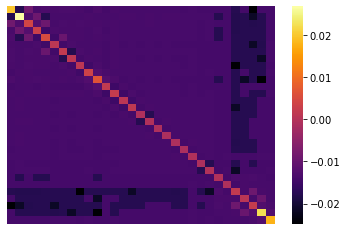

In [9]:
print(np.shape(covset))
split = 0.8
ntrain = int(split * numMatrix)
indx = [ntrain]
covset_train, covset_test = np.split(covset, indx, axis=0)
covset_noise_train, covset_noise_test = np.split(covset_noise, indx, axis=0)

sns.heatmap(pd.DataFrame(covset_noise_test[0]), 
# sns.heatmap(pd.DataFrame(covset_test[0]), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

covset_train = covset_train.reshape((len(covset_train), np.prod(covset_train.shape[1:])))
covset_test = covset_test.reshape((len(covset_test), np.prod(covset_test.shape[1:])))
covset_noise_train = covset_noise_train.reshape((len(covset_noise_train), np.prod(covset_noise_train.shape[1:])))
covset_noise_test = covset_noise_test.reshape((len(covset_noise_test), np.prod(covset_noise_test.shape[1:])))



In [10]:
# input_cov = Input(shape=(31, 31, 1))

# This is the size of our encoded representations
encoding_dim = 31  

# This is our input image
input_img = tf.keras.Input(shape=(31*31,))
# begin encoder
x = layers.Dense(1000, activation='tanh')(input_img)
x = layers.Dropout(0.2)(x)
x = layers.Dense(500, activation='tanh')(x)
x = layers.Dropout(0.2)(x)
encoded = layers.Dense(encoding_dim, activation='tanh')(x)
x = layers.Dropout(0.2)(encoded)
#begin decoder
x = layers.Dense(500, activation='tanh')(x)
x = layers.Dropout(0.2)(x)
x = layers.Dense(1000, activation='tanh')(x)
x = layers.Dropout(0.2)(x)
decoded = layers.Dense(31*31, activation='linear')(x)


# This model maps an input to its reconstruction
autoencoder = tf.keras.Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')
autoencoder.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 961)]             0         
_________________________________________________________________
dense (Dense)                (None, 1000)              962000    
_________________________________________________________________
dropout (Dropout)            (None, 1000)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 500)               500500    
_________________________________________________________________
dropout_1 (Dropout)          (None, 500)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 100)               50100     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0     

In [11]:
encoder = tf.keras.Model(input_img, encoded)
# This is our encoded (32-dimensional) input
encoded_input = tf.keras.Input(shape=(encoding_dim,))

decoder_layer1 = autoencoder.layers[-5]
decoder_layer2 = autoencoder.layers[-4]
decoder_layer3 = autoencoder.layers[-3]
decoder_layer4 = autoencoder.layers[-2]
decoder_layer5 = autoencoder.layers[-1]

# create the decoder model
decoder = Model(encoded_input, 
                decoder_layer5(decoder_layer4(decoder_layer3(decoder_layer2(decoder_layer1(encoded_input))))))

In [12]:
callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min',
                                   min_delta=0,
                                   patience=10, 
                                   restore_best_weights=True)]

autoencoder_train = autoencoder.fit(covset_noise_train, covset_train,
                epochs=1000,
                batch_size=32,
#                 shuffle=True,
                validation_data=(covset_noise_test, covset_test))
#                 callbacks=callbacks)
#                 callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

Epoch 1/1000
250/250 [==============================] - 4s 16ms/step - loss: 2.4074e-05 - val_loss: 3.3055e-07
Epoch 2/1000
250/250 [==============================] - 4s 15ms/step - loss: 4.4869e-07 - val_loss: 6.5317e-07
Epoch 3/1000
250/250 [==============================] - 4s 15ms/step - loss: 8.7057e-07 - val_loss: 2.2193e-07
Epoch 4/1000
250/250 [==============================] - 4s 16ms/step - loss: 6.2529e-07 - val_loss: 1.2476e-07
Epoch 5/1000
250/250 [==============================] - 4s 17ms/step - loss: 3.5578e-07 - val_loss: 1.1111e-07
Epoch 6/1000
250/250 [==============================] - 4s 16ms/step - loss: 3.3009e-07 - val_loss: 1.5994e-07
Epoch 7/1000
250/250 [==============================] - 4s 14ms/step - loss: 4.2404e-07 - val_loss: 9.3676e-08
Epoch 8/1000
250/250 [==============================] - 4s 14ms/step - loss: 2.3920e-07 - val_loss: 1.0712e-07
Epoch 9/1000
250/250 [==============================] - 4s 14ms/step - loss: 3.0702e-07 - val_loss: 4.4967e-08
E

250/250 [==============================] - 4s 14ms/step - loss: 9.8692e-08 - val_loss: 2.2184e-08
Epoch 75/1000
250/250 [==============================] - 4s 14ms/step - loss: 1.0264e-07 - val_loss: 5.4127e-08
Epoch 76/1000
250/250 [==============================] - 4s 14ms/step - loss: 1.1463e-07 - val_loss: 5.6503e-08
Epoch 77/1000
250/250 [==============================] - 4s 14ms/step - loss: 1.2578e-07 - val_loss: 5.7180e-08
Epoch 78/1000
250/250 [==============================] - 4s 14ms/step - loss: 1.9116e-07 - val_loss: 4.2249e-08
Epoch 79/1000
250/250 [==============================] - 4s 14ms/step - loss: 9.4763e-08 - val_loss: 2.6925e-08
Epoch 80/1000
250/250 [==============================] - 4s 14ms/step - loss: 1.3570e-07 - val_loss: 4.3223e-08
Epoch 81/1000
250/250 [==============================] - 4s 14ms/step - loss: 1.1072e-07 - val_loss: 5.4571e-08
Epoch 82/1000
250/250 [==============================] - 4s 14ms/step - loss: 9.5721e-08 - val_loss: 2.5610e-08
Epoch 

Epoch 147/1000
250/250 [==============================] - 4s 14ms/step - loss: 9.0992e-08 - val_loss: 2.7162e-08
Epoch 148/1000
250/250 [==============================] - 4s 14ms/step - loss: 1.0933e-07 - val_loss: 3.5476e-08
Epoch 149/1000
250/250 [==============================] - 4s 14ms/step - loss: 9.3673e-08 - val_loss: 4.1237e-08
Epoch 150/1000
250/250 [==============================] - 4s 14ms/step - loss: 1.0276e-07 - val_loss: 1.3164e-07
Epoch 151/1000
250/250 [==============================] - 4s 14ms/step - loss: 8.6627e-08 - val_loss: 3.2506e-08
Epoch 152/1000
250/250 [==============================] - 4s 14ms/step - loss: 8.1179e-08 - val_loss: 1.9421e-08
Epoch 153/1000
250/250 [==============================] - 4s 14ms/step - loss: 7.9185e-08 - val_loss: 3.0101e-08
Epoch 154/1000
250/250 [==============================] - 4s 14ms/step - loss: 8.0206e-08 - val_loss: 2.0642e-08
Epoch 155/1000
250/250 [==============================] - 4s 14ms/step - loss: 1.0752e-07 - val_

250/250 [==============================] - 4s 14ms/step - loss: 7.1845e-08 - val_loss: 1.4931e-08
Epoch 220/1000
250/250 [==============================] - 4s 14ms/step - loss: 7.9428e-08 - val_loss: 1.5754e-08
Epoch 221/1000
250/250 [==============================] - 4s 14ms/step - loss: 6.0765e-08 - val_loss: 1.8622e-08
Epoch 222/1000
250/250 [==============================] - 4s 14ms/step - loss: 8.5708e-08 - val_loss: 2.1051e-08
Epoch 223/1000
250/250 [==============================] - 4s 14ms/step - loss: 8.1085e-08 - val_loss: 1.8856e-08
Epoch 224/1000
250/250 [==============================] - 4s 14ms/step - loss: 6.5438e-08 - val_loss: 3.3806e-08
Epoch 225/1000
250/250 [==============================] - 4s 14ms/step - loss: 6.6110e-08 - val_loss: 3.7671e-08
Epoch 226/1000
250/250 [==============================] - 4s 14ms/step - loss: 7.0774e-08 - val_loss: 1.7081e-08
Epoch 227/1000
250/250 [==============================] - 4s 14ms/step - loss: 6.6966e-08 - val_loss: 1.3158e-0

250/250 [==============================] - 4s 14ms/step - loss: 5.0175e-08 - val_loss: 3.7033e-08
Epoch 292/1000
250/250 [==============================] - 4s 14ms/step - loss: 6.7692e-08 - val_loss: 6.6790e-08
Epoch 293/1000
250/250 [==============================] - 4s 14ms/step - loss: 7.1868e-08 - val_loss: 2.0209e-08
Epoch 294/1000
250/250 [==============================] - 4s 14ms/step - loss: 6.7542e-08 - val_loss: 2.4835e-08
Epoch 295/1000
250/250 [==============================] - 4s 14ms/step - loss: 5.6205e-08 - val_loss: 1.4280e-08
Epoch 296/1000
250/250 [==============================] - 4s 14ms/step - loss: 5.9424e-08 - val_loss: 1.1560e-08
Epoch 297/1000
250/250 [==============================] - 4s 14ms/step - loss: 7.6009e-08 - val_loss: 5.4826e-08
Epoch 298/1000
250/250 [==============================] - 4s 14ms/step - loss: 6.9001e-08 - val_loss: 1.3376e-08
Epoch 299/1000
250/250 [==============================] - 4s 14ms/step - loss: 6.5342e-08 - val_loss: 2.6954e-0

250/250 [==============================] - 4s 14ms/step - loss: 5.6402e-08 - val_loss: 1.6268e-08
Epoch 364/1000
250/250 [==============================] - 4s 14ms/step - loss: 5.6105e-08 - val_loss: 1.4282e-08
Epoch 365/1000
250/250 [==============================] - 4s 14ms/step - loss: 4.4688e-08 - val_loss: 3.9378e-08
Epoch 366/1000
250/250 [==============================] - 4s 14ms/step - loss: 7.0524e-08 - val_loss: 2.9085e-08
Epoch 367/1000
250/250 [==============================] - 4s 14ms/step - loss: 4.5180e-08 - val_loss: 1.7068e-08
Epoch 368/1000
250/250 [==============================] - 4s 14ms/step - loss: 4.5507e-08 - val_loss: 3.6398e-08
Epoch 369/1000
250/250 [==============================] - 4s 14ms/step - loss: 6.7817e-08 - val_loss: 1.3915e-08
Epoch 370/1000
250/250 [==============================] - 4s 14ms/step - loss: 6.3181e-08 - val_loss: 9.3221e-09
Epoch 371/1000
250/250 [==============================] - 4s 14ms/step - loss: 4.6068e-08 - val_loss: 1.0048e-0

250/250 [==============================] - 4s 14ms/step - loss: 4.4741e-08 - val_loss: 8.8051e-09
Epoch 436/1000
250/250 [==============================] - 4s 14ms/step - loss: 4.7369e-08 - val_loss: 4.0616e-08
Epoch 437/1000
250/250 [==============================] - 4s 14ms/step - loss: 5.8446e-08 - val_loss: 3.4907e-08
Epoch 438/1000
250/250 [==============================] - 4s 14ms/step - loss: 4.5569e-08 - val_loss: 1.6937e-08
Epoch 439/1000
250/250 [==============================] - 4s 14ms/step - loss: 4.6744e-08 - val_loss: 1.7903e-08
Epoch 440/1000
250/250 [==============================] - 4s 14ms/step - loss: 6.0748e-08 - val_loss: 5.5512e-08
Epoch 441/1000
250/250 [==============================] - 4s 14ms/step - loss: 4.4382e-08 - val_loss: 1.8697e-08
Epoch 442/1000
250/250 [==============================] - 4s 14ms/step - loss: 4.5962e-08 - val_loss: 4.8939e-08
Epoch 443/1000
250/250 [==============================] - 4s 14ms/step - loss: 4.3545e-08 - val_loss: 1.4116e-0

250/250 [==============================] - 4s 14ms/step - loss: 4.0212e-08 - val_loss: 7.5840e-09
Epoch 508/1000
250/250 [==============================] - 4s 14ms/step - loss: 4.4298e-08 - val_loss: 1.1388e-08
Epoch 509/1000
250/250 [==============================] - 4s 14ms/step - loss: 3.7454e-08 - val_loss: 1.2651e-08
Epoch 510/1000
250/250 [==============================] - 4s 14ms/step - loss: 4.7534e-08 - val_loss: 1.8928e-08
Epoch 511/1000
250/250 [==============================] - 4s 14ms/step - loss: 4.9277e-08 - val_loss: 2.7490e-08
Epoch 512/1000
250/250 [==============================] - 4s 14ms/step - loss: 4.3534e-08 - val_loss: 1.4663e-08
Epoch 513/1000
250/250 [==============================] - 4s 14ms/step - loss: 4.3256e-08 - val_loss: 2.7563e-08
Epoch 514/1000
250/250 [==============================] - 4s 14ms/step - loss: 4.8234e-08 - val_loss: 7.9744e-09
Epoch 515/1000
250/250 [==============================] - 4s 14ms/step - loss: 3.7549e-08 - val_loss: 8.3584e-0

250/250 [==============================] - 6s 25ms/step - loss: 4.4916e-08 - val_loss: 1.7318e-08
Epoch 580/1000
250/250 [==============================] - 7s 26ms/step - loss: 4.1856e-08 - val_loss: 1.8973e-08
Epoch 581/1000
250/250 [==============================] - 6s 24ms/step - loss: 3.8277e-08 - val_loss: 9.7584e-09
Epoch 582/1000
250/250 [==============================] - 6s 25ms/step - loss: 3.9588e-08 - val_loss: 9.5015e-09
Epoch 583/1000
250/250 [==============================] - 6s 26ms/step - loss: 3.8852e-08 - val_loss: 1.1184e-08
Epoch 584/1000
250/250 [==============================] - 6s 25ms/step - loss: 4.5143e-08 - val_loss: 1.7349e-08
Epoch 585/1000
250/250 [==============================] - 6s 24ms/step - loss: 4.5559e-08 - val_loss: 9.0220e-09
Epoch 586/1000
250/250 [==============================] - 6s 23ms/step - loss: 3.5277e-08 - val_loss: 1.2073e-08
Epoch 587/1000
250/250 [==============================] - 6s 22ms/step - loss: 3.9217e-08 - val_loss: 1.1324e-0

250/250 [==============================] - 4s 15ms/step - loss: 4.2083e-08 - val_loss: 7.0294e-09
Epoch 652/1000
250/250 [==============================] - 4s 14ms/step - loss: 3.2438e-08 - val_loss: 7.3239e-09
Epoch 653/1000
250/250 [==============================] - 3s 14ms/step - loss: 4.4382e-08 - val_loss: 8.0188e-09
Epoch 654/1000
250/250 [==============================] - 4s 14ms/step - loss: 3.3927e-08 - val_loss: 2.4655e-08
Epoch 655/1000
250/250 [==============================] - 4s 14ms/step - loss: 3.2271e-08 - val_loss: 8.2204e-09
Epoch 656/1000
250/250 [==============================] - 4s 14ms/step - loss: 3.1201e-08 - val_loss: 7.2666e-09
Epoch 657/1000
250/250 [==============================] - 4s 14ms/step - loss: 3.5165e-08 - val_loss: 2.0068e-08
Epoch 658/1000
250/250 [==============================] - 4s 14ms/step - loss: 4.1696e-08 - val_loss: 6.4891e-09
Epoch 659/1000
250/250 [==============================] - 3s 14ms/step - loss: 3.5421e-08 - val_loss: 1.9540e-0

250/250 [==============================] - 4s 18ms/step - loss: 3.5360e-08 - val_loss: 1.2718e-08
Epoch 724/1000
250/250 [==============================] - 4s 15ms/step - loss: 3.4789e-08 - val_loss: 7.6345e-09
Epoch 725/1000
250/250 [==============================] - 4s 16ms/step - loss: 3.4091e-08 - val_loss: 7.7184e-09
Epoch 726/1000
250/250 [==============================] - 4s 15ms/step - loss: 3.5837e-08 - val_loss: 5.3399e-09
Epoch 727/1000
250/250 [==============================] - 4s 15ms/step - loss: 3.3736e-08 - val_loss: 9.1234e-09
Epoch 728/1000
250/250 [==============================] - 4s 16ms/step - loss: 3.2440e-08 - val_loss: 9.8989e-09
Epoch 729/1000
250/250 [==============================] - 4s 17ms/step - loss: 4.7033e-08 - val_loss: 1.1481e-08
Epoch 730/1000
250/250 [==============================] - 4s 15ms/step - loss: 3.8297e-08 - val_loss: 2.1179e-08
Epoch 731/1000
250/250 [==============================] - 4s 14ms/step - loss: 3.2069e-08 - val_loss: 9.0883e-0

250/250 [==============================] - 4s 16ms/step - loss: 2.8061e-08 - val_loss: 1.5671e-08
Epoch 796/1000
250/250 [==============================] - 4s 15ms/step - loss: 3.6989e-08 - val_loss: 2.4138e-08
Epoch 797/1000
250/250 [==============================] - 3s 14ms/step - loss: 3.9239e-08 - val_loss: 9.6243e-09
Epoch 798/1000
250/250 [==============================] - 3s 14ms/step - loss: 2.8010e-08 - val_loss: 5.1167e-09
Epoch 799/1000
250/250 [==============================] - 3s 14ms/step - loss: 2.7843e-08 - val_loss: 3.8197e-08
Epoch 800/1000
250/250 [==============================] - 4s 14ms/step - loss: 3.5601e-08 - val_loss: 3.7895e-08
Epoch 801/1000
250/250 [==============================] - 4s 14ms/step - loss: 3.8075e-08 - val_loss: 8.8540e-09
Epoch 802/1000
250/250 [==============================] - 4s 15ms/step - loss: 3.4196e-08 - val_loss: 6.8281e-09
Epoch 803/1000
250/250 [==============================] - 4s 15ms/step - loss: 2.8047e-08 - val_loss: 6.8874e-0

250/250 [==============================] - 4s 15ms/step - loss: 3.1267e-08 - val_loss: 1.3124e-08
Epoch 868/1000
250/250 [==============================] - 4s 14ms/step - loss: 3.8463e-08 - val_loss: 1.9712e-08
Epoch 869/1000
250/250 [==============================] - 3s 14ms/step - loss: 2.9630e-08 - val_loss: 9.9454e-09
Epoch 870/1000
250/250 [==============================] - 3s 14ms/step - loss: 3.2062e-08 - val_loss: 7.8923e-09
Epoch 871/1000
250/250 [==============================] - 4s 14ms/step - loss: 2.6422e-08 - val_loss: 3.1006e-08
Epoch 872/1000
250/250 [==============================] - 4s 14ms/step - loss: 3.6045e-08 - val_loss: 8.5937e-09
Epoch 873/1000
250/250 [==============================] - 4s 15ms/step - loss: 3.0782e-08 - val_loss: 5.2113e-09
Epoch 874/1000
250/250 [==============================] - 4s 15ms/step - loss: 2.7932e-08 - val_loss: 4.9621e-09
Epoch 875/1000
250/250 [==============================] - 4s 15ms/step - loss: 2.8837e-08 - val_loss: 1.6745e-0

250/250 [==============================] - 4s 18ms/step - loss: 3.0336e-08 - val_loss: 6.6615e-08
Epoch 940/1000
250/250 [==============================] - 4s 17ms/step - loss: 3.5357e-08 - val_loss: 8.4227e-09
Epoch 941/1000
250/250 [==============================] - 5s 18ms/step - loss: 2.4586e-08 - val_loss: 8.4598e-09
Epoch 942/1000
250/250 [==============================] - 4s 16ms/step - loss: 2.8040e-08 - val_loss: 1.8758e-08
Epoch 943/1000
250/250 [==============================] - 4s 16ms/step - loss: 2.9044e-08 - val_loss: 1.1909e-08
Epoch 944/1000
250/250 [==============================] - 4s 16ms/step - loss: 2.5536e-08 - val_loss: 1.1104e-08
Epoch 945/1000
250/250 [==============================] - 4s 16ms/step - loss: 2.5316e-08 - val_loss: 6.3223e-09
Epoch 946/1000
250/250 [==============================] - 4s 15ms/step - loss: 2.6966e-08 - val_loss: 7.0354e-09
Epoch 947/1000
250/250 [==============================] - 4s 16ms/step - loss: 2.6629e-08 - val_loss: 1.1432e-0

(array([-1.e-06,  0.e+00,  1.e-06,  2.e-06,  3.e-06,  4.e-06,  5.e-06,
         6.e-06,  7.e-06]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

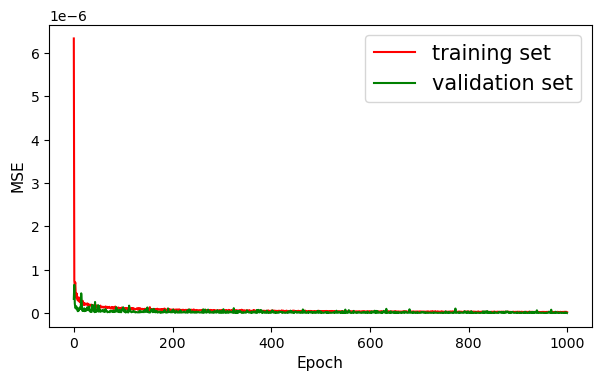

In [13]:
plt.figure(figsize=(7, 4), dpi=100)

plt.plot(autoencoder_train.history['loss'], color='r', )
plt.plot(autoencoder_train.history['val_loss'], color='g')

plt.ylabel('MSE', fontsize=11)
plt.xlabel('Epoch', fontsize=11)
plt.legend(['training set', 'validation set'], loc='upper right', fontsize=15)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
# plt.title('Autoencoder', fontsize=8)
# plt.savefig('loss_binned_JLA_.png')

In [14]:
unet = np.sqrt(np.min(autoencoder_train.history['val_loss']))
print(unet**2, np.min(autoencoder_train.history['loss']))

4.27350466125631e-09 2.2498406693216566e-08


In [15]:
encoded_imgs = encoder.predict(covset_test)
decoded_imgs = decoder.predict(encoded_imgs)
print(np.shape(encoded_imgs))
df = pd.DataFrame(encoded_imgs)
# np.min(encoded_imgs)

(2000, 100)


(2000, 961)


<AxesSubplot:>

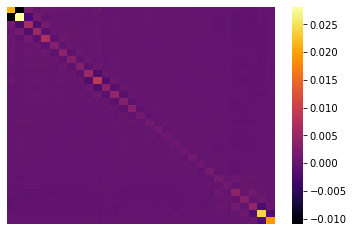

In [16]:
print(np.shape(decoded_imgs))

sns.heatmap(pd.DataFrame(decoded_imgs[0].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)
# plt.savefig("decoded_img22.png")
# this cov matrix work well within Bayesian inference
# np.savetxt("test.dat", decoded_imgs[0].reshape(31,31), delimiter= " ", header="#fake COV")


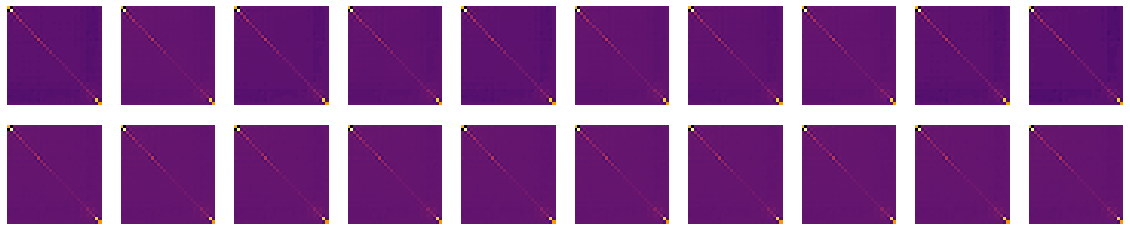

In [17]:
n = 10  # How many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # Display original
    ax = plt.subplot(2, n, i + 1)
    sns.heatmap(covset_test[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
    # Display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    sns.heatmap(decoded_imgs[i].reshape(31, 31), cbar=False, fmt='g', xticklabels=False, yticklabels=False, 
                cmap = 'inferno')
# plt.savefig('predicted_covs_binned_jla.png', dpi=200)

### Now we use randz (fake z) as inpute of the decoder neural netkork. But it is worth to make a mapping

$z_{original} \rightarrow encoded_{vals} \implies z_{original} \alpha =  encoded_{vals} \implies \alpha = \frac{encoded}{z_{original}}$

So, for fake z:

$encoded_{fake} = \alpha z_{fake}$



In [18]:
file2 = '/home/cosmocicatais/Documents/github/neuralCosmoReconstruction/data/jla_binned_distances_31nodes_v1.txt'
data = pd.read_csv(file2, names=['z', '$D_L$'], sep = " ", skiprows=3)
z = data.values[:,0]
dl = data.values[:,1:]

In [19]:
# fake_encoded = np.zeros((1, 31))
# avg_encoded = np.mean(encoded_imgs, axis=0)
# print(np.shape(avg_encoded))
# np.savetxt('avg_encoded.txt', avg_encoded, fmt='%.15e')
# ranz = z
# randl = dl+0.01

In [20]:
# for i, avg in enumerate(avg_encoded):
# #     alpha = avg/z[i]
#     alpha = avg/dl[i]
# #     fake_encoded[0, i] = alpha * ranz[i]
#     fake_encoded[0, i] = alpha * randl[i]

In [21]:
# decoded_fake = decoder.predict(fake_encoded)
# np.shape(decoded_fake), np.shape(fake_encoded)

In [22]:
# decoded_fake[0, :]

<AxesSubplot:>

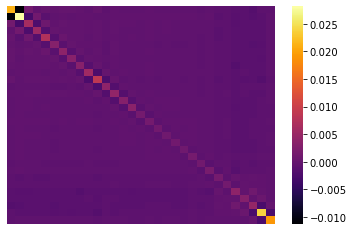

In [23]:
testmatrix = np.zeros((31,31))
err = np.random.rand() 
for row in range(nsize):
    for col in range(nsize):
        if row == col:
            testmatrix[row, col] = syscov[row, col]
        else:
            testmatrix[row, col] = syscov[row, col] + err*0.005*orderMag(syscov[row, col])

clean_img = autoencoder.predict(testmatrix.reshape(-1, 31*31,))
# clean_img = autoencoder.predict(covset_noise_test[0].reshape(-1, 31*31,))
# plt.savefig('fake_cov_jla.png', dpi=200)
# np.min(np.abs(decoded_fake[0, :]))]
sns.heatmap(pd.DataFrame(testmatrix), 
        fmt='g', xticklabels=False, yticklabels=False, 
        cmap = 'inferno', cbar=True,
        robust=False)

<AxesSubplot:>

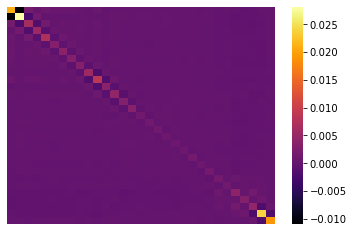

In [24]:
sns.heatmap(pd.DataFrame(clean_img[0].reshape(31,31)), 
            fmt='g', xticklabels=False, yticklabels=False, 
            cmap = 'inferno', 
            robust=False)


In [25]:
# clean_img = autoencoder.predict(clean_img)
# # clean_img = autoencoder.predict(covset_noise_test[0].reshape(-1, 31*31,))
# # plt.savefig('fake_cov_jla.png', dpi=200)
# # np.min(np.abs(decoded_fake[0, :]))]
# sns.heatmap(clean_img, 
#         fmt='g', xticklabels=False, yticklabels=False, 
#         cmap = 'inferno', cbar=True,
#         robust=False)

In [34]:
np.savetxt("fake_binned_JLA_COVdecodedTEST1.dat", clean_img.reshape(31,31), delimiter= " ", header="#fake COV")


In [27]:
autoencoder.save('../models/autoencoderJLA.h5')
decoder.save('../models/decoderJLA.h5')
encoder.save('../models/encoderJLA.h5')

In [28]:
# np.min(np.abs(syscov - decoded_fake[0, :].reshape(31,31)))

In [29]:
# np.max(decoded_fake[0, :].reshape(31,31))

In [30]:
np.max(syscov)

0.02815552265

In [31]:
# np.min(decoded_fake[0, :].reshape(31,31))

In [32]:
# np.min(np.abs(syscov))